In [1]:
%load_ext autoreload
%autoreload 2
import logging
import json
import pandas
import pathlib
from dateutil import parser
from collections import Counter
import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt

logging.getLogger("matplotlib").setLevel(logging.WARNING)

results_path = "results"

def get_dataframe(result_files):
    reviews = []
    sessions = []
    trainings = []
    tags = []
    for result_file in result_files:
        logging.info(f"load dataframe fom {result_file}")
        with open(result_file) as f:
            result = json.load(f)
            f.close()

            user = (
                result["user"].get("id")
                if isinstance(result["user"], dict)
                else result["user"]
            )
            landing_datetime = parser.isoparse(result["landingDate"]).astimezone()
            start_datetime = parser.isoparse(result["startDate"]).astimezone()
            end_datetime = parser.isoparse(result["endDate"]).astimezone()

            row = [
                {
                    "user": user,
                    "landing": landing_datetime,
                    "start": start_datetime,
                    "end": end_datetime,
                }
            ]


            df_session = pandas.DataFrame.from_dict(data=row, orient="columns")
                
            df_review = pandas.DataFrame.from_dict(
                data=result["reviews"], orient="columns"
            )
        
            df_review["user"] = user

            reviews.append(df_review)
            sessions.append(df_session)

            row_tag = []

            for review in result["reviews"]:
                for word in review["selectedWords"]:
                    if word == "autre":
                        continue                    
                    tag = {
                        "expression":review['expression'],
                        "tag":word,
                    }
                    row_tag.append(tag)

                for word in review["freeResponses"]:
                    if word == "autre":
                        continue                    
                    tag = {
                        "expression":review['expression'],
                        "freeTag":word.lower(),
                    }
                    row_tag.append(tag)

            df_tag = pandas.DataFrame.from_dict(data=row_tag, orient="columns")                       
            tags.append(df_tag)
                
            if result.get("training"):
                df_training = pandas.DataFrame.from_dict(
                    data=result["training"], orient="columns"
                )
                trainings.append(df_training)

            logging.info(f"read results {user}")   

    return sessions, reviews, trainings, tags


Statistiques générales

In [2]:
result_files = list(pathlib.Path(results_path).rglob("*.json"))
sessions, reviews, training, tags = get_dataframe(result_files)
df_reviews = pandas.concat(reviews)
df_reviews = df_reviews.astype({'name': 'int32'})
df_tags = pandas.concat(tags)

print(f"Nombre de participants : {len(reviews)}")
print(f"Nombre de videos annotées : {len(df_reviews)}")
print(f"Nombre total d'adjectifs renseignés: {len(df_tags)} dont {df_tags['freeTag'].count()} saisis en champ libre.")
print(f"Nombre moyen d'adjectifs par video: {len(df_tags)/len(df_reviews):.2f}")
print(f"Nombre d'adjectifs différents suggérés: {len(df_tags['tag'][df_tags['tag'].notnull()].unique())}")
print(f"Nombre d'adjectifs différents saisis: {len(df_tags['freeTag'][df_tags['freeTag'].notnull()].unique())}")

Nombre de participants : 865
Nombre de videos annotées : 51800
Nombre total d'adjectifs renseignés: 130498 dont 2668 saisis en champ libre.
Nombre moyen d'adjectifs par video: 2.52
Nombre d'adjectifs différents suggérés: 132
Nombre d'adjectifs différents saisis: 767


In [3]:
print('Repartition des expressions : ')
print(df_reviews['expression'].value_counts())

Repartition des expressions : 
expression
NEUTRE          26140
SUPPLIANT        2954
INCREDULE        2643
EVIDENCE         2578
RECONFORTANT     2566
ENTHOUSIASTE     2503
PENSIF           2352
COLERE           2339
ETONNE           2278
DESOLE           1973
DETERMINE        1949
ESPIEGLE         1525
Name: count, dtype: int64


Adjectifs suggérés les plus fréquents par Attitudes

/tmp/ipykernel_7480/72287559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='tag', y='expression', palette="Blues_r").set_title(expression)
/tmp/ipykernel_7480/72287559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='tag', y='expression', palette="Blues_r").set_title(expression)
/tmp/ipykernel_7480/72287559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='tag', y='expression', palette="Blues_r").set_title(expression)
/tmp/ipykernel_7480/72287559.py:5: FutureWarning:

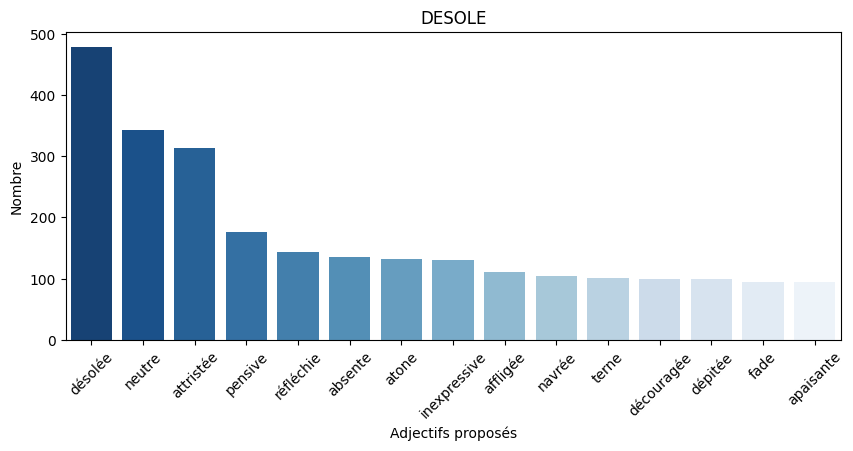

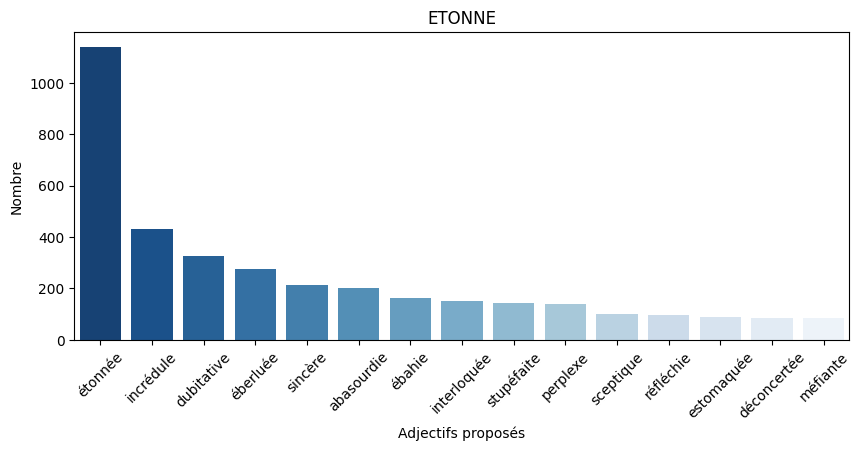

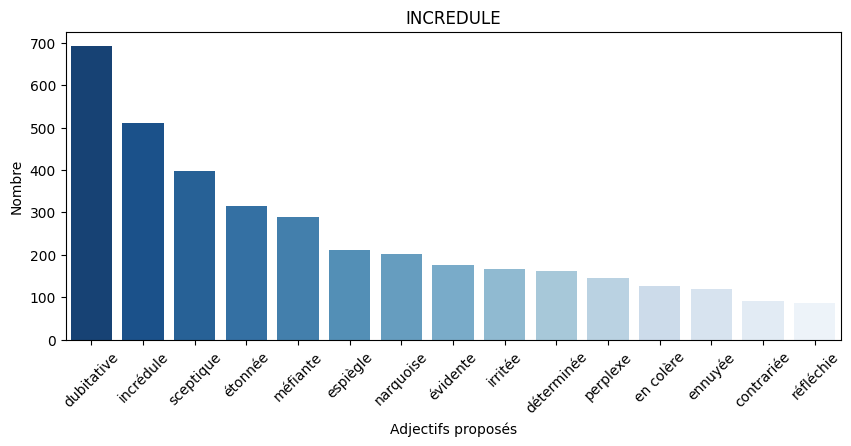

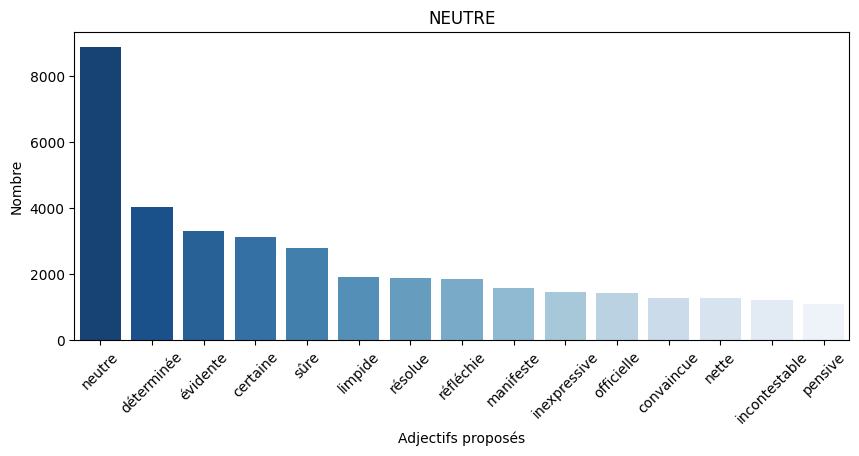

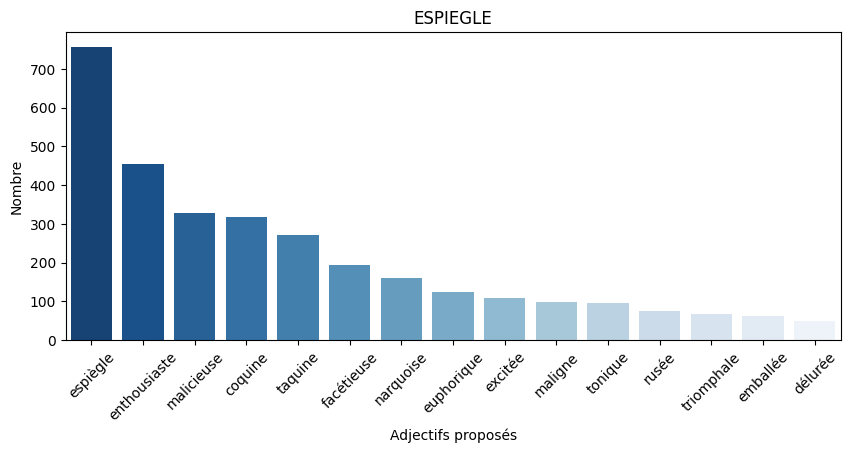

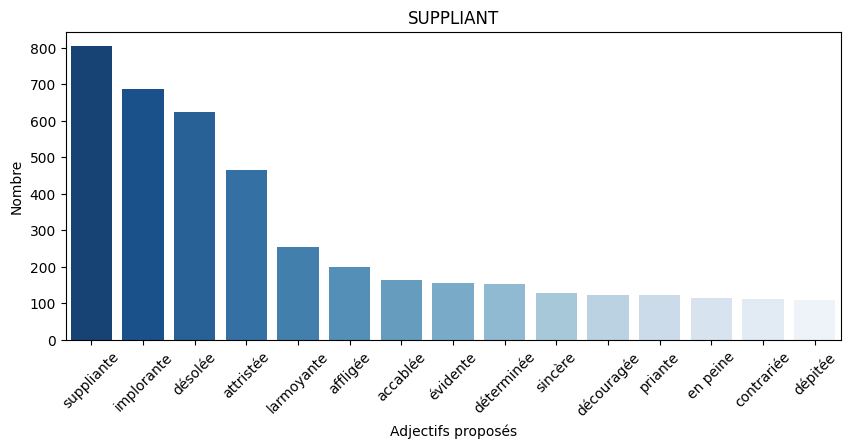

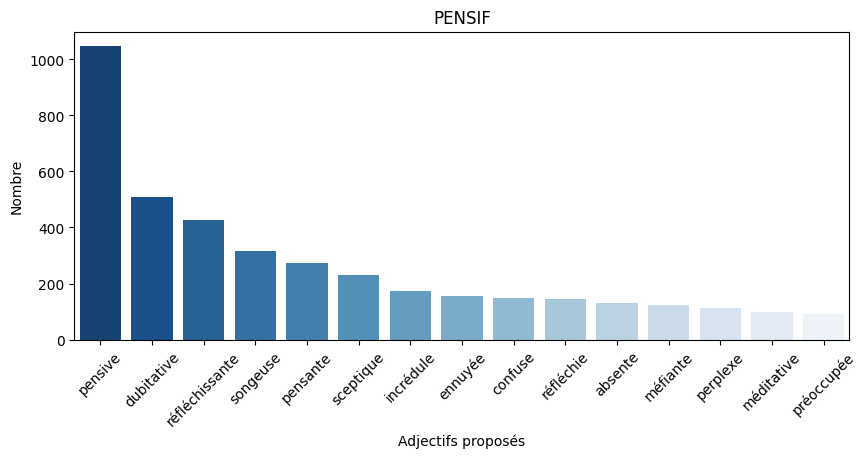

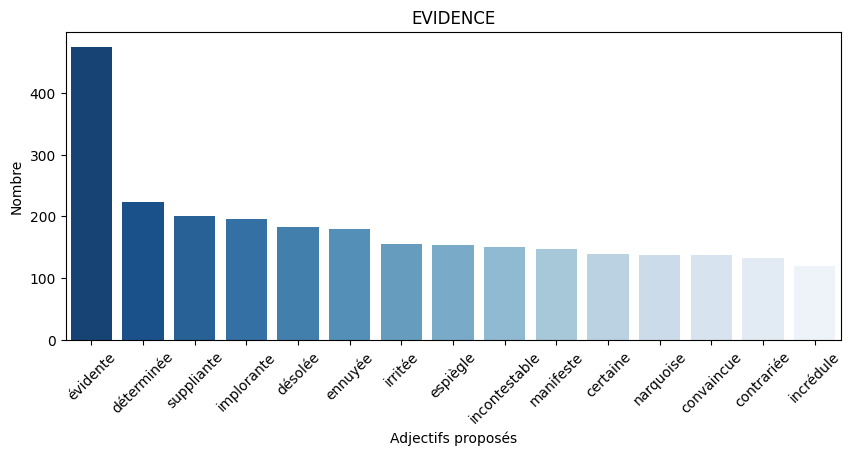

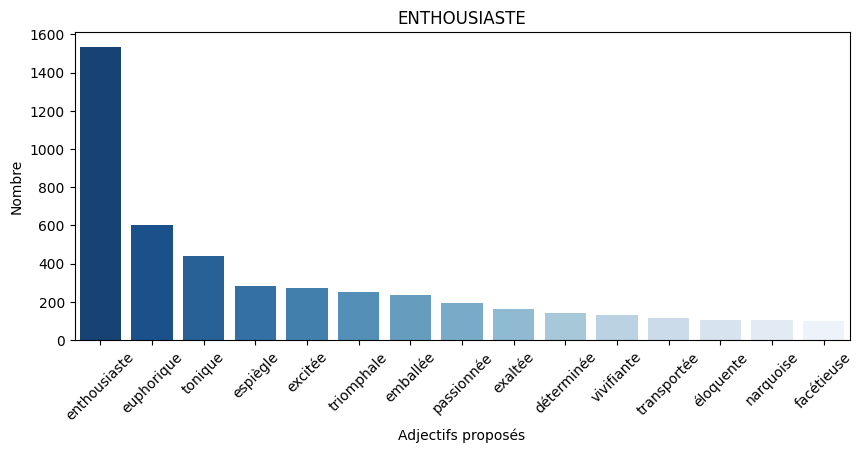

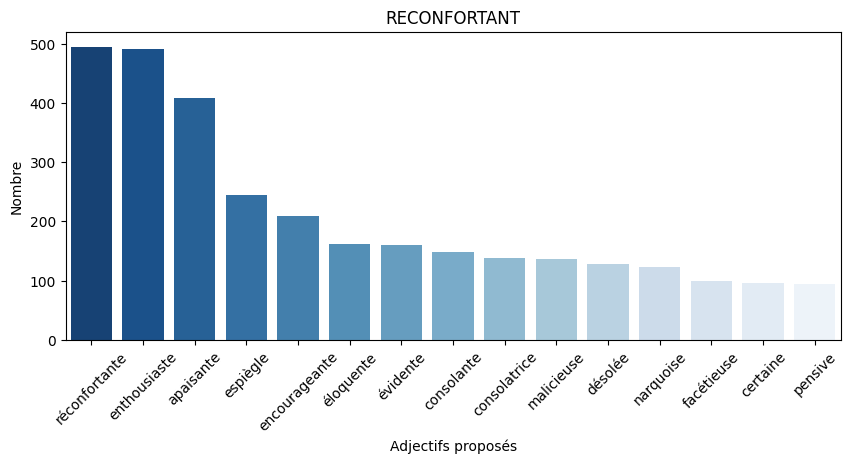

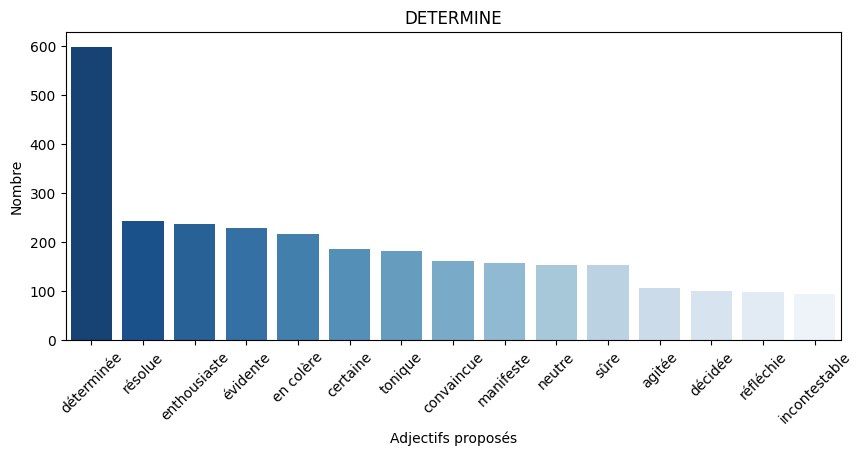

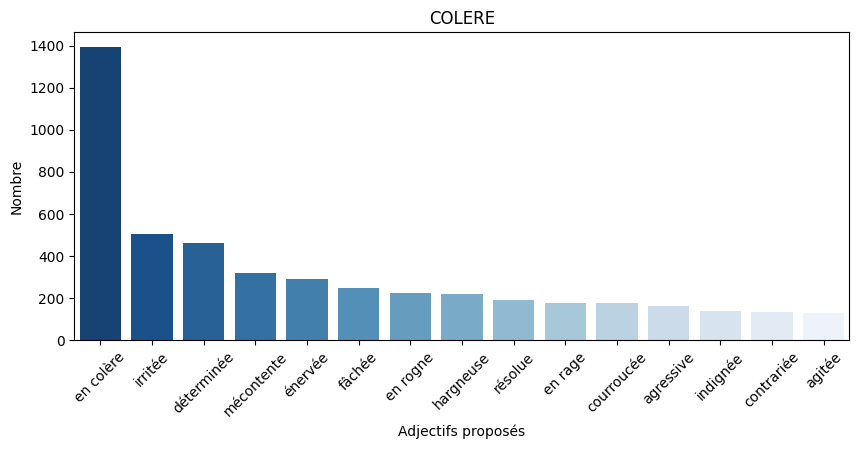

In [4]:
for expression in df_tags['expression'].unique().tolist():
    df_tag_expression = df_tags[df_tags['expression']==expression][['expression', 'tag']]
    df_plot = df_tag_expression.groupby('tag').count().sort_values("expression",ascending=False).head(n=15).reset_index()
    plt.figure(figsize=(10,4))
    ax = sns.barplot(data=df_plot, x='tag', y='expression', palette="Blues_r").set_title(expression)
    plt.xticks(rotation=45)
    plt.xlabel('Adjectifs proposés')
    plt.ylabel('Nombre')


In [5]:
pandas.set_option("display.max_colwidth",1000)
pandas.set_option("display.max_rows",500)

def parseTag(tags):
    x = tags.dropna()
    x = Counter(x).most_common(15)
    return x, len(tags.unique())

print("=== Attitudes suggérées ===")
print(df_tags.groupby('expression').agg({'tag':lambda x: parseTag(x)}))

=== Attitudes suggérées ===
                                                                                                                                                                                                                                                                                                       tag
expression                                                                                                                                                                                                                                                                                                
COLERE                          ([(en colère, 1394), (irritée, 504), (déterminée, 461), (mécontente, 318), (énervée, 290), (fâchée, 249), (en rogne, 224), (hargneuse, 219), (résolue, 193), (en rage, 179), (courroucée, 177), (agressive, 164), (indignée, 138), (contrariée, 133), (agitée, 130)], 119)
DESOLE                                         ([(désolée, 479), (neutre, 3

Adjectifs saisis les plus fréquents par Attitudes

/tmp/ipykernel_7480/2021071892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='freeTag', y='expression', palette="Blues_r").set_title(expression)
/tmp/ipykernel_7480/2021071892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='freeTag', y='expression', palette="Blues_r").set_title(expression)
/tmp/ipykernel_7480/2021071892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='freeTag', y='expression', palette="Blues_r").set_title(expression)
/tmp/ipykernel_7480/2021071892.

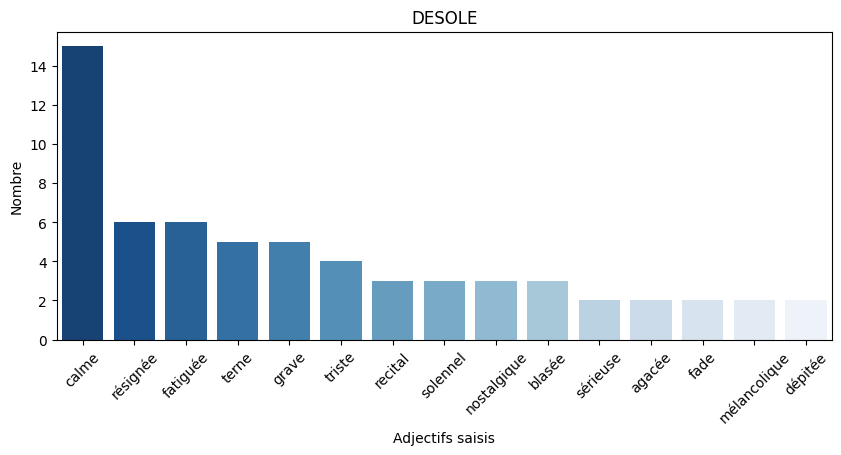

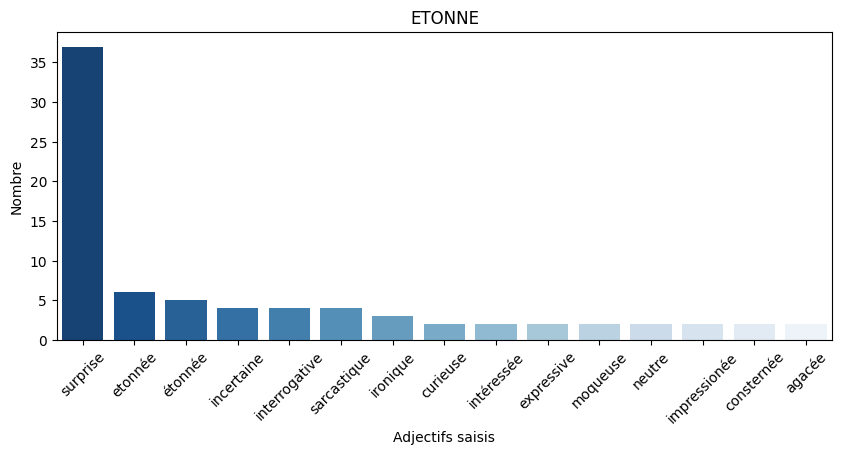

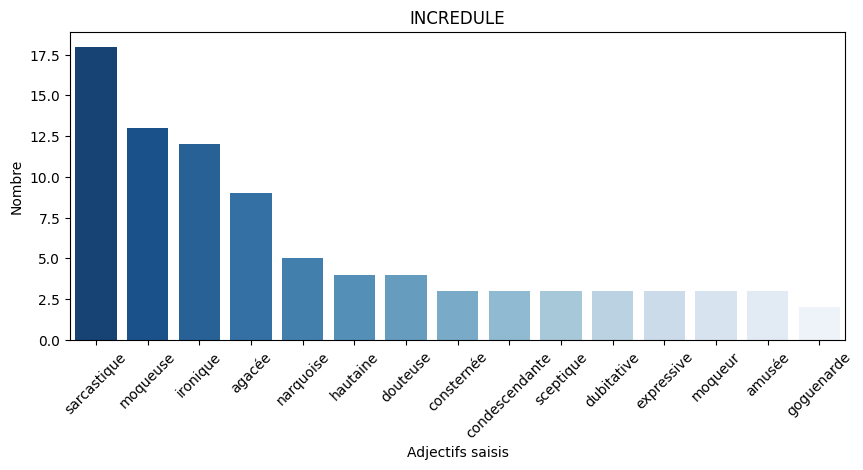

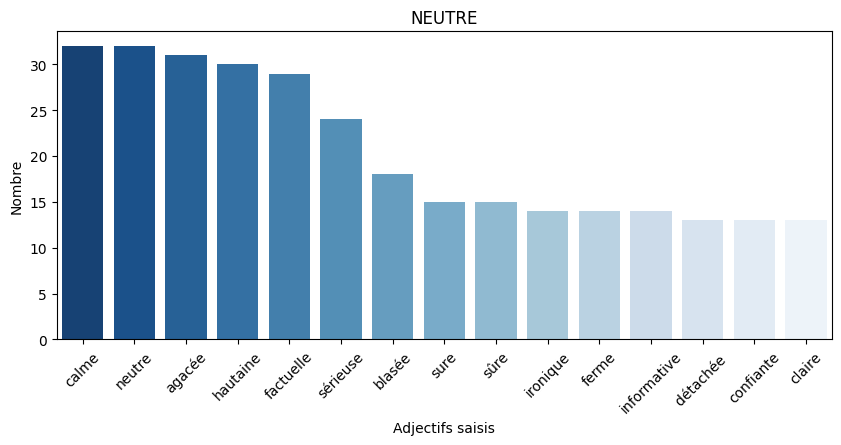

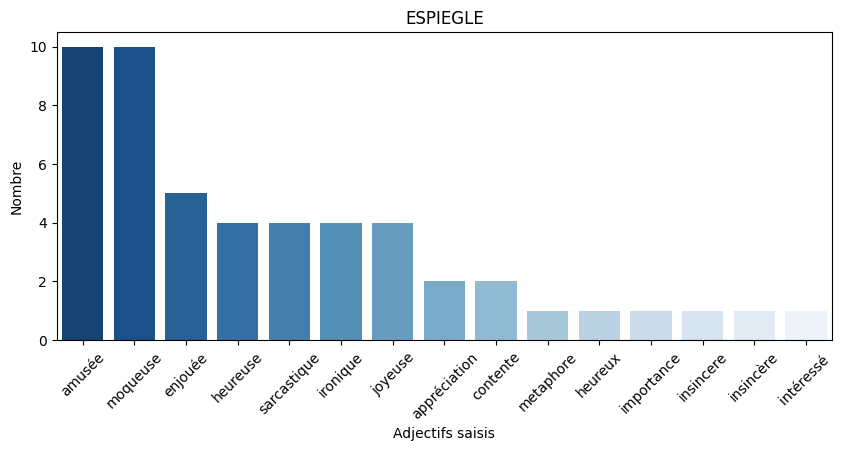

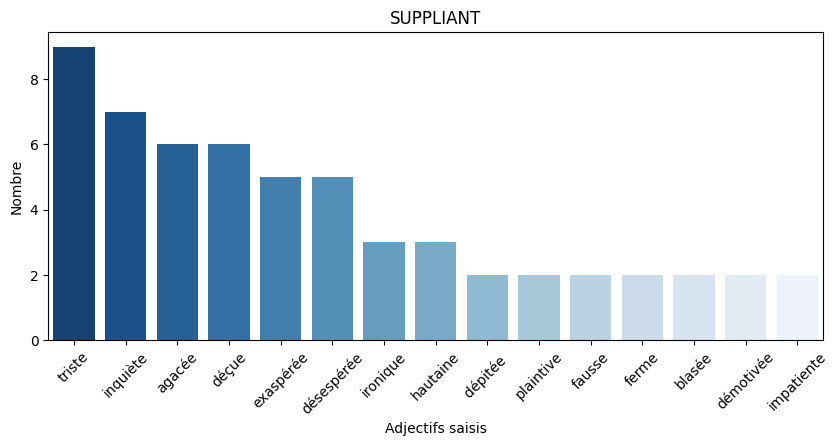

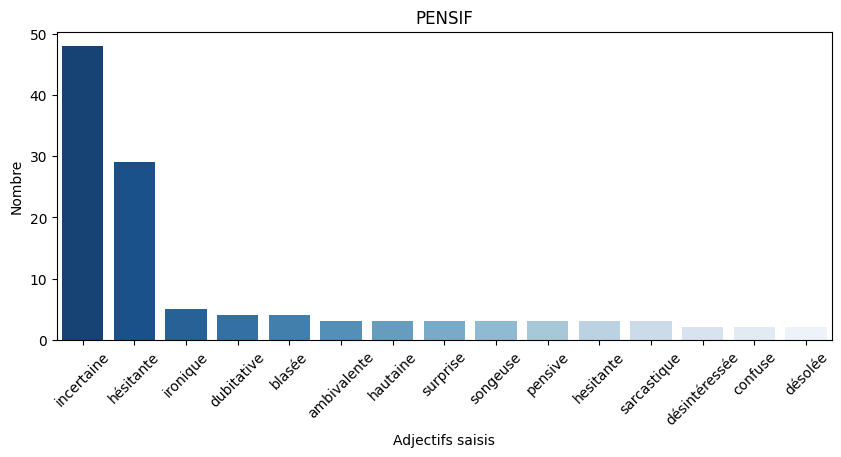

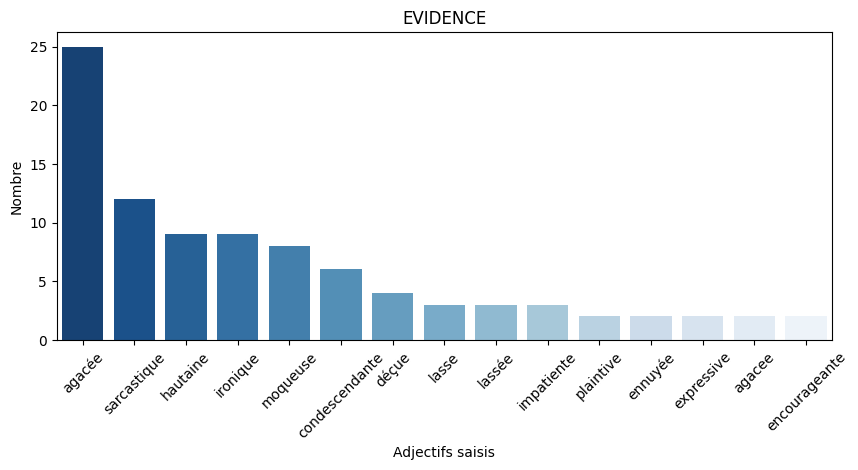

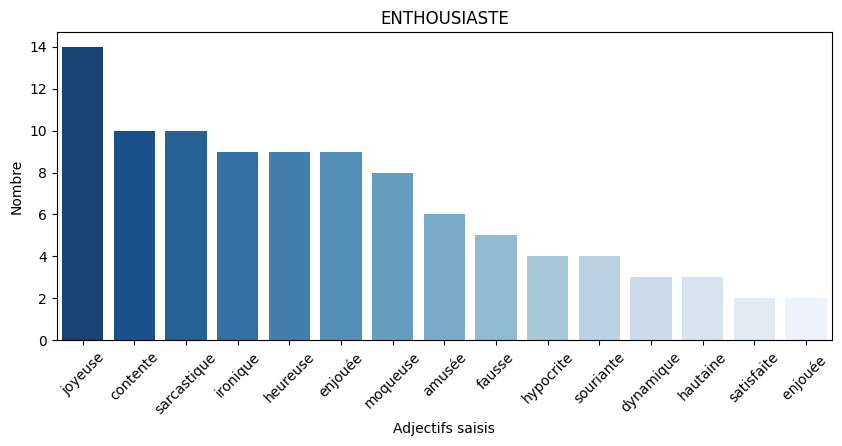

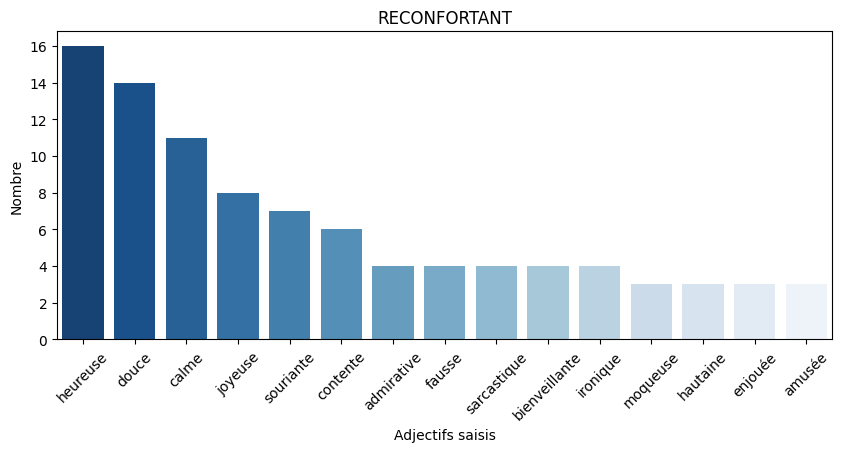

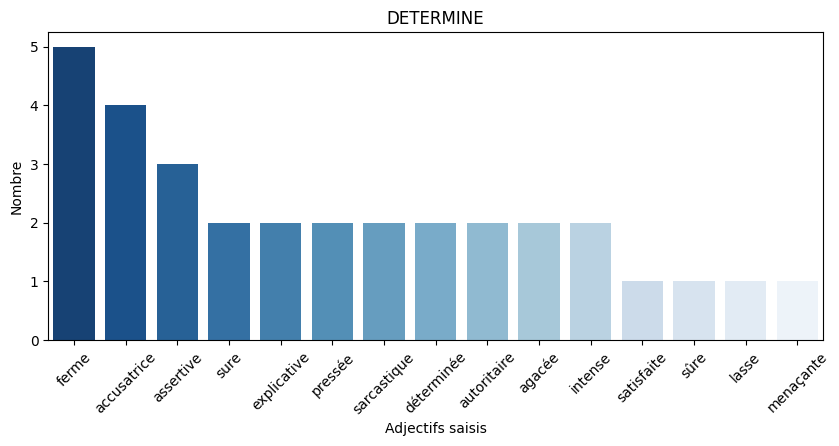

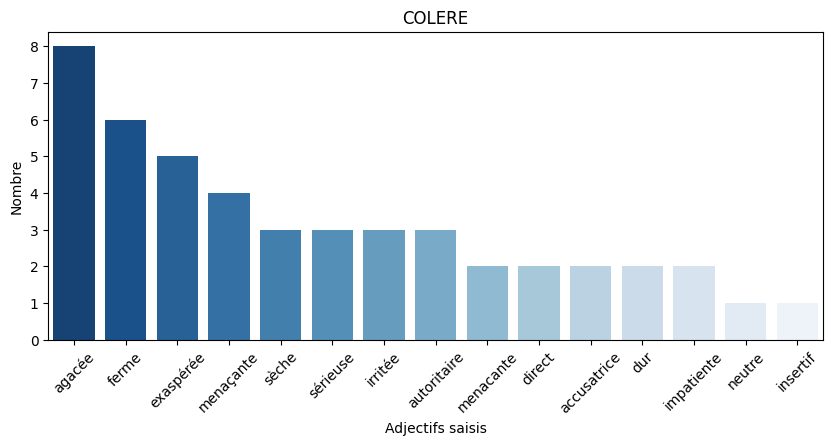

In [6]:
for expression in df_tags['expression'].unique().tolist():
    df_tag_expression = df_tags[df_tags['expression']==expression][['expression', 'freeTag']]
    df_plot = df_tag_expression.groupby('freeTag').count().sort_values("expression",ascending=False).head(n=15).reset_index()
    plt.figure(figsize=(10,4))
    ax = sns.barplot(data=df_plot, x='freeTag', y='expression', palette="Blues_r").set_title(expression)
    plt.xticks(rotation=45)
    plt.xlabel('Adjectifs saisis')
    plt.ylabel('Nombre')


In [7]:
print("==== Champ libre ===")
print(df_tags.groupby('expression').agg({'freeTag':lambda x: parseTag(x)}))

==== Champ libre ===
                                                                                                                                                                                                                                                                  freeTag
expression                                                                                                                                                                                                                                                               
COLERE                                   ([(agacée, 8), (ferme, 6), (exaspérée, 5), (menaçante, 4), (sérieuse, 3), (autoritaire, 3), (irritée, 3), (sèche, 3), (accusatrice, 2), (menacante, 2), (direct, 2), (dur, 2), (impatiente, 2), (froide, 1), (haineuse, 1)], 70)
DESOLE                                           ([(calme, 15), (résignée, 6), (fatiguée, 6), (grave, 5), (terne, 5), (triste, 4), (nostalgique, 3), (blasée, 3), (solennel, 3), (rec